**Covid-19 Sentiment Analysis**

**Context**

I collect recent tweets about the COVID-19 vaccines used in entire world on large scale, as following:

- Pfizer/BioNTech;
- Sinopharm;
- Sinovac;
- Moderna;
- Oxford/AstraZeneca;
- Covaxin;
- Sputnik V.

**Data collection**

The data is collected using tweepy Python package to access Twitter API. For each of the vaccine I use relevant search term (most frequently used in Twitter to refer to the respective vaccine)

**Data collection frequency**

Initial data was merged from tweets about Pfizer/BioNTech vaccine. I added then tweets from Sinopharm, Sinovac (both Chinese-produced vaccines), Moderna, Oxford/Astra-Zeneca, Covaxin and Sputnik V vaccines. The collection was in the first days twice a day, until I identified approximatively the new tweets quota and then collection (for all vaccines) stabilized at once a day, during morning hours (GMT).

**Inspiration**

You can perform multiple operations on the vaccines tweets. Here are few possible suggestions:

- Study the subjects of recent tweets about the vaccine made by various producers;
- Perform various NLP tasks on this data source (topic modelling, sentiment analysis);
- Using the COVID-19 World Vaccination Progress (where we can see the progress of the vaccinations and the countries where the vaccines are administered), you can study the relationship between the vaccination progress and the discussions in social media (from the tweets) about the vaccines.



*Kaggle Dataset*
- https://www.kaggle.com/c/tweet-sentiment-extraction

- https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets



---
**Load Packages**

In [1]:
import warnings
warnings.simplefilter("ignore")

import re
import numpy as np 
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import gensim  # https://pypi.org/project/gensim/
import nltk #https://www.nltk.org/
from nltk.sentiment import SentimentIntensityAnalyzer #https://www.nltk.org/api/nltk.sentiment.html
from textblob import TextBlob #https://textblob.readthedocs.io/en/dev/
from wordcloud import WordCloud, STOPWORDS #https://pypi.org/project/wordcloud/

from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer

import tensorflow as tf
import plotly.express as px


In [2]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
from keras.preprocessing.text import Tokenizer
#for confusion matrix
import seaborn
from sklearn.metrics import confusion_matrix
import keras

Load the Dataset vaccination_all_tweets.csv 

In [3]:
tweets_df = pd.read_csv('update_vaccination_all_tweets.csv')
tweets_df.head(10)

id             user_name  ... favorites is_retweet
0  1340539111971516416            Rachel Roh  ...         0      False
1  1338158543359250433           Albert Fong  ...         1      False
2  1337858199140118533              eli🇱🇹🇪🇺👌  ...         0      False
3  1337855739918835717         Charles Adler  ...      2129      False
4  1337854064604966912  Citizen News Channel  ...         0      False
5  1337852648389832708                   Dee  ...         0      False
6  1337851215875608579     Gunther Fehlinger  ...         4      False
7  1337850832256176136   Dr.Krutika Kuppalli  ...        22      False
8  1337850023531347969           Erin Despas  ...         1      False
9  1337842295857623042          Ch.Amjad Ali  ...         0      False

[10 rows x 16 columns]

In [4]:
print(f'The Dataset shape is:',tweets_df.shape)

The Dataset shape is: (125906, 16)


So we have 125906 rows and 16 columns

In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125906 entries, 0 to 125905
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                125906 non-null  int64 
 1   user_name         125906 non-null  object
 2   user_location     89972 non-null   object
 3   user_description  116833 non-null  object
 4   user_created      125906 non-null  object
 5   user_followers    125906 non-null  int64 
 6   user_friends      125906 non-null  int64 
 7   user_favourites   125906 non-null  int64 
 8   user_verified     125906 non-null  bool  
 9   date              125906 non-null  object
 10  text              125906 non-null  object
 11  hashtags          101894 non-null  object
 12  source            125787 non-null  object
 13  retweets          125906 non-null  int64 
 14  favorites         125906 non-null  int64 
 15  is_retweet        125906 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory

In [6]:
tweets_df.describe()

id  user_followers  ...       retweets      favorites
count  1.259060e+05    1.259060e+05  ...  125906.000000  125906.000000
mean   1.385793e+18    1.106664e+05  ...       2.976872      13.274046
std    1.740242e+16    8.887440e+05  ...      55.194169     194.277738
min    1.337728e+18    0.000000e+00  ...       0.000000       0.000000
25%    1.372300e+18    1.070000e+02  ...       0.000000       0.000000
50%    1.383376e+18    5.460000e+02  ...       0.000000       1.000000
75%    1.402291e+18    2.092000e+03  ...       1.000000       3.000000
max    1.410706e+18    1.578068e+07  ...   11288.000000   25724.000000

[8 rows x 6 columns]

**Missing Data**

In [7]:
#Lets find out the mising data
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))


In [8]:
missing_data(tweets_df)

id user_name user_location  ... retweets favorites is_retweet
Total        0         0         35934  ...        0         0          0
Percent      0         0       28.5403  ...        0         0          0
Types    int64    object        object  ...    int64     int64       bool

[3 rows x 16 columns]

**Unique Value**

In [9]:
#Unique values
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

In [10]:
unique_values(tweets_df)

id  user_name  user_location  ...  retweets  favorites  is_retweet
Total    125906     125906          89972  ...    125906     125906      125906
Uniques  125906      58117          18361  ...       373        848           1

[2 rows x 16 columns]

**Most frequent values**

In [11]:
def most_frequent_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        itm = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(itm)
        vals.append(val)
    tt['Most frequent item'] = items
    tt['Frequence'] = vals
    tt['Percent from total'] = np.round(vals / total * 100, 3)
    return(np.transpose(tt))

In [12]:
most_frequent_values(tweets_df)

id       user_name  ... favorites is_retweet
Total                            125906          125906  ...    125906     125906
Most frequent item  1364449897190027270  CowinBangalore  ...         0      False
Frequence                             1            7462  ...     57986     125906
Percent from total                0.001           5.927  ...    46.055        100

[4 rows x 16 columns]

**Visualize the Data Distribution**

In [13]:
def plot_count(feature, title, df, size=1, ordered=True):
    f, ax = plt.subplots(1,1, figsize=(4*size,4),)
    total = float(len(df))
    if ordered:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='RdBu')
    else:
        g = sns.countplot(df[feature], palette='RdBu')
    g.set_title("Number and percentage of {}\n".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=10)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2. ,height, ' {:1.2f}% '.format(100*height/total), ha="center")
    plt.show()  

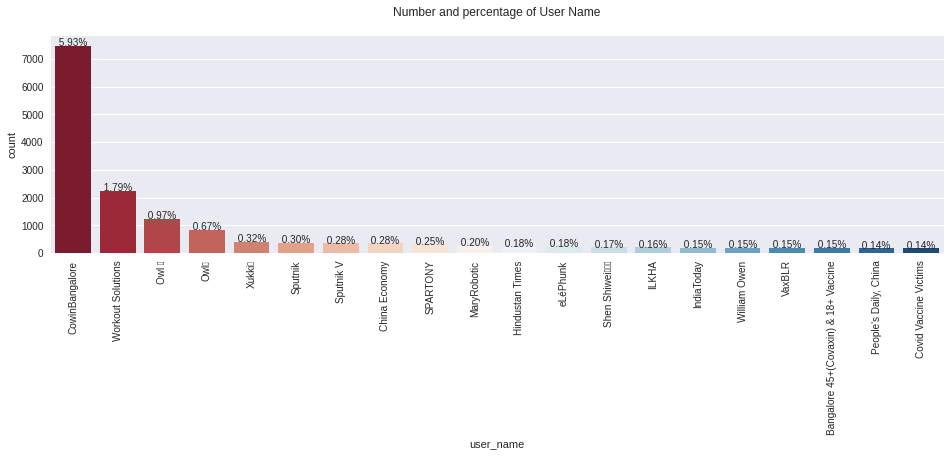

In [14]:
# User Name
plot_count('user_name' , "User Name" , tweets_df , 4)

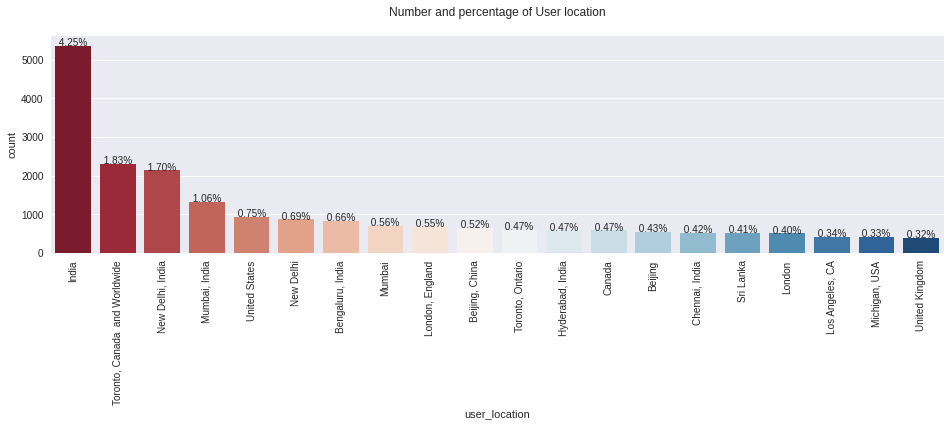

In [15]:
# User Location
plot_count("user_location", "User location", tweets_df,4)

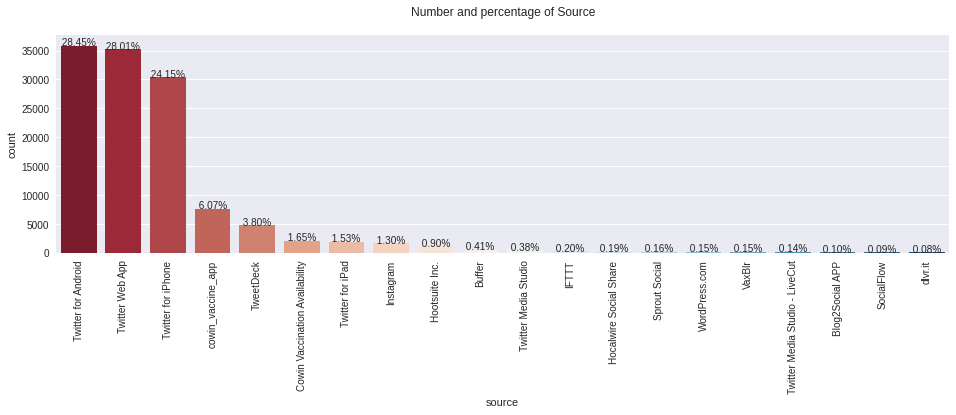

In [16]:
#Tweet Source 
plot_count("source", "Source", tweets_df,4)

**Word Cloud**

In [17]:
#Make a word Cloud from dataset
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [19]:
def show_wordcloud(data, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=40, max_words=700,background_color="#002210").generate(text)
    fig = plt.figure(1, figsize=(20,20))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.style.use('ggplot')
    plt.show()

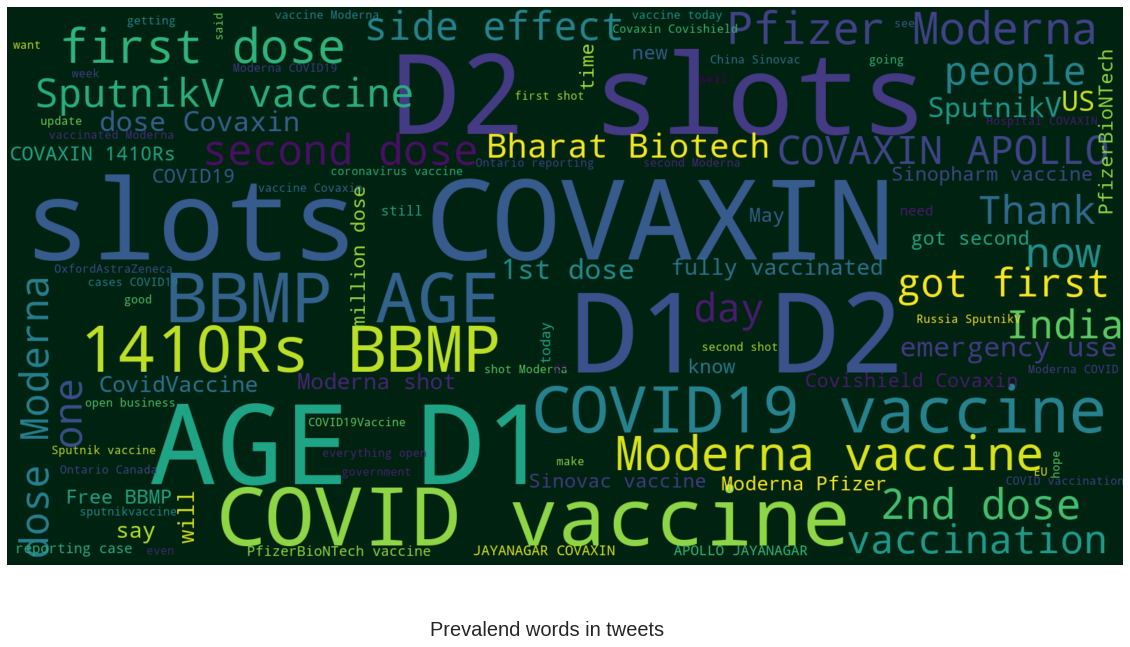

In [20]:
show_wordcloud(tweets_df['text'] , title = 'Prevalend words in tweets')

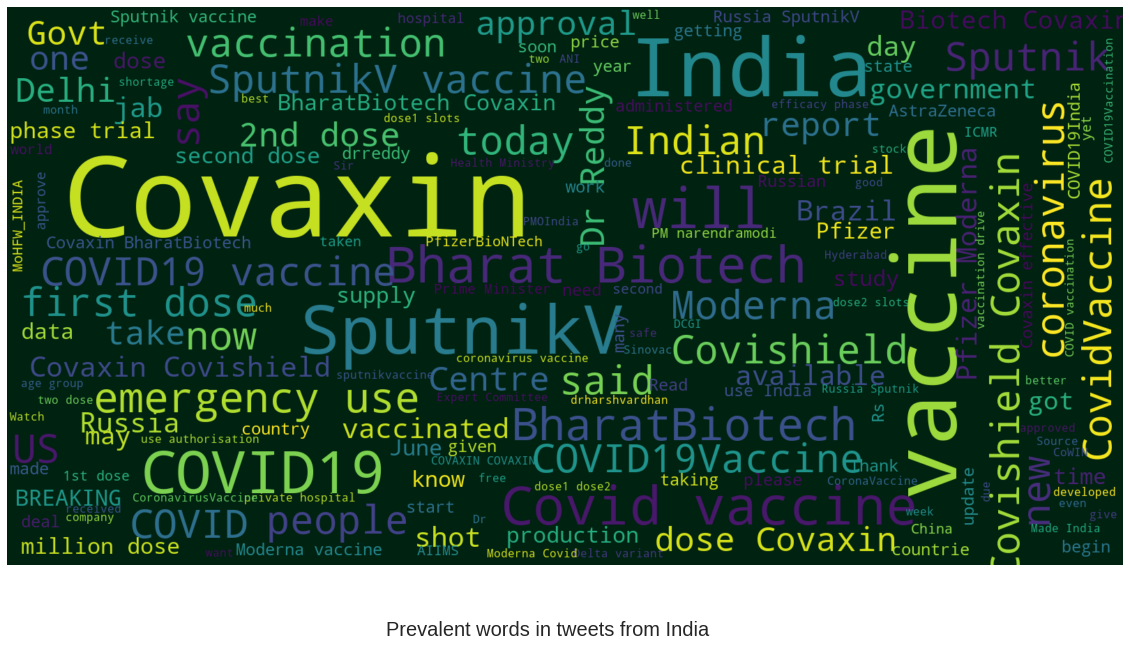

In [21]:
# India
india_df = tweets_df.loc[tweets_df.user_location=="India"]
show_wordcloud(india_df['text'], title = 'Prevalent words in tweets from India')

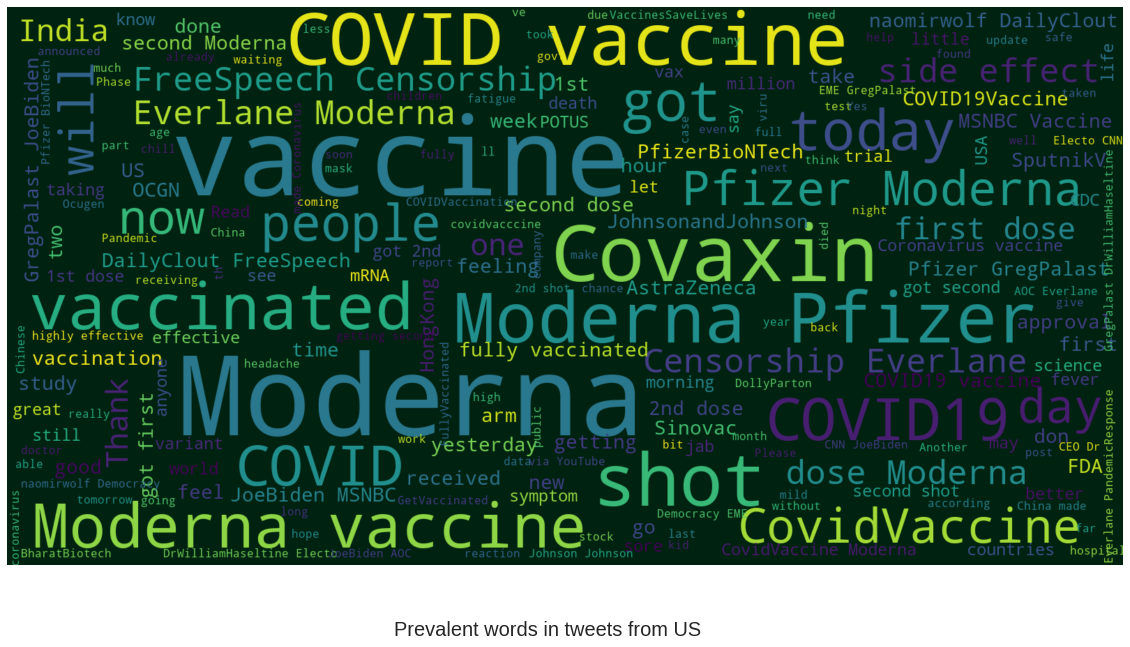

In [22]:
# From USA
us_df = tweets_df.loc[tweets_df.user_location=="United States"]
show_wordcloud(us_df['text'], title = 'Prevalent words in tweets from US')

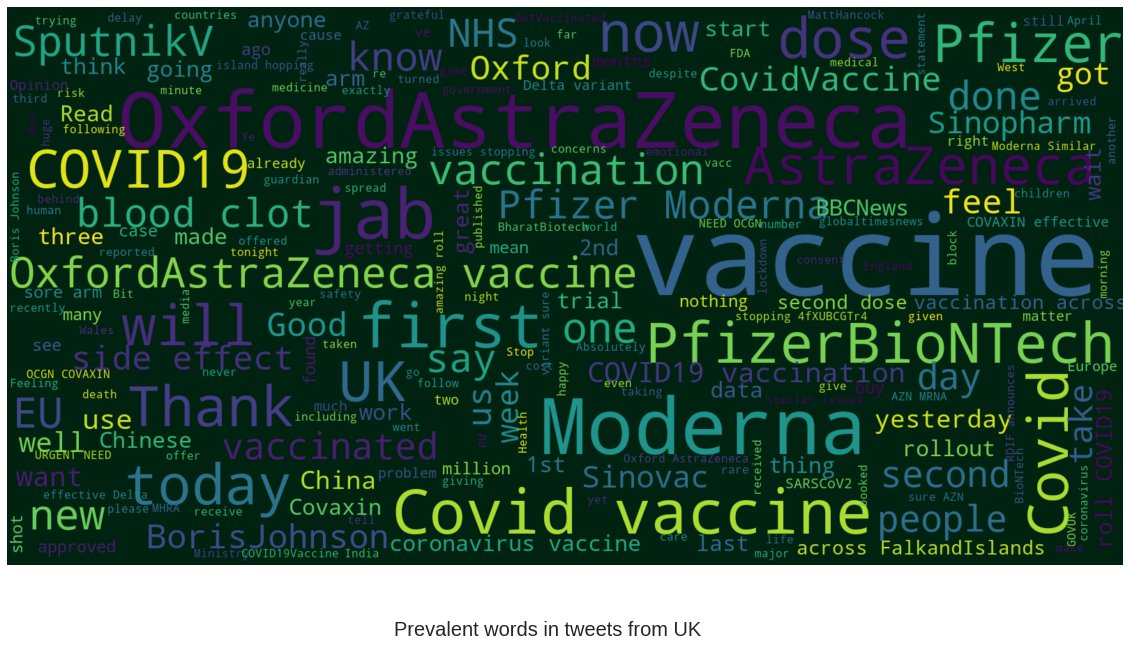

In [23]:
# From UK
uk_df = tweets_df.loc[tweets_df.user_location=="United Kingdom"]
show_wordcloud(uk_df['text'], title = 'Prevalent words in tweets from UK')

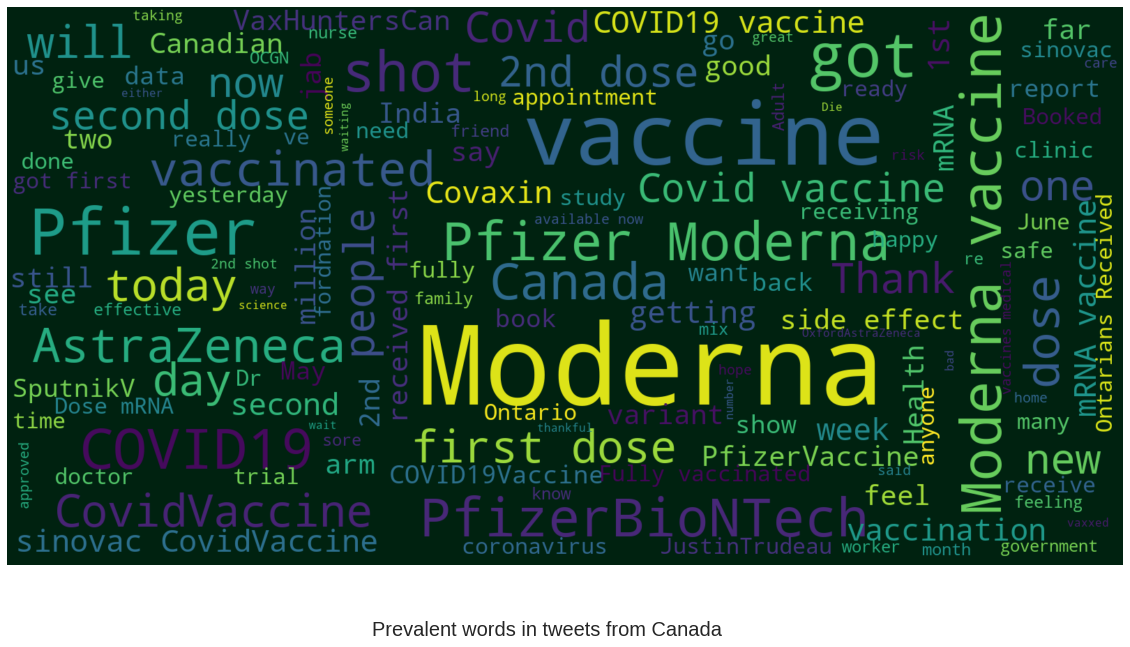

In [24]:
# From Canada
ca_df = tweets_df.loc[tweets_df.user_location=="Canada"]
show_wordcloud(ca_df['text'], title = 'Prevalent words in tweets from Canada')

**Hashtags Analysis**

In [25]:
def plot_features_distribution(features, title, df, isLog=False):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        if(isLog):
            sns.distplot(np.log1p(df[feature]),kde=True,hist=False, bins=120, label=feature,color='blue')
        else:
            sns.distplot(df[feature],kde=True, hist=False, bins=120, label=feature,color='blue')
    plt.xlabel('')
    plt.legend()
    plt.show()

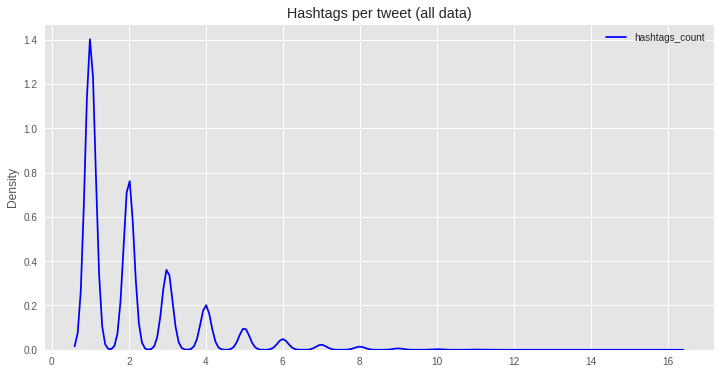

In [26]:
tweets_df['hashtags'] = tweets_df['hashtags'].replace(np.nan, "['None']", regex=True)
tweets_df['hashtags'] = tweets_df['hashtags'].apply(lambda x: x.replace('\\N',''))
tweets_df['hashtags_count'] = tweets_df['hashtags'].apply(lambda x: len(x.split(',')))
plot_features_distribution(['hashtags_count'], 'Hashtags per tweet (all data)', tweets_df)

In [27]:
tweets_df['hashtags_individual'] = tweets_df['hashtags'].apply(lambda x: x.split(','))
from itertools import chain
all_hashtags = set(chain.from_iterable(list(tweets_df['hashtags_individual'])))
print(f"There are totally Hastags of : {len(all_hashtags)}")

There are totally Hastags of : 28938


In [28]:
tweets_df['datedt'] = pd.to_datetime(tweets_df['date'])
tweets_df['year'] = tweets_df['datedt'].dt.year
tweets_df['month'] = tweets_df['datedt'].dt.month
tweets_df['day'] = tweets_df['datedt'].dt.day
tweets_df['dayofweek'] = tweets_df['datedt'].dt.dayofweek
tweets_df['hour'] = tweets_df['datedt'].dt.hour
tweets_df['minute'] = tweets_df['datedt'].dt.minute
tweets_df['dayofyear'] = tweets_df['datedt'].dt.dayofyear
tweets_df['date_only'] = tweets_df['datedt'].dt.date

In [29]:
tweets_agg_df = tweets_df.groupby(["date_only"])["text"].count().reset_index()
tweets_agg_df.columns = ["date_only", "count"]

In [30]:
def plot_time_variation(df, x='date_only', y='count', hue=None, size=1, title="", is_log=False):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    g = sns.lineplot(x=x, y=y, hue=hue, data=df)
    plt.xticks(rotation=90)
    if hue:
        plt.title(f'{y} grouped by {hue} | {title}')
    else:
        plt.title(f'{y} | {title}')
    if(is_log):
        ax.set(yscale="log")
    ax.grid(color='black', linestyle='dotted', linewidth=0.75)
    plt.show() 

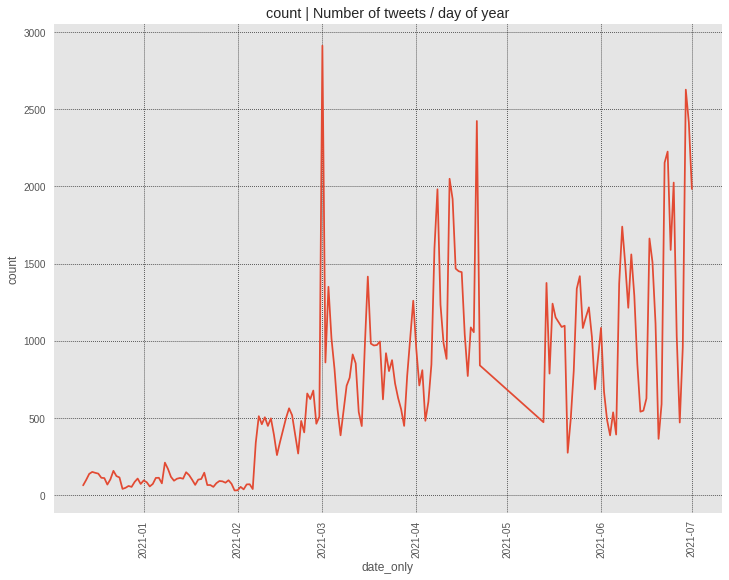

In [31]:
plot_time_variation(tweets_agg_df, title="Number of tweets / day of year",size=3)

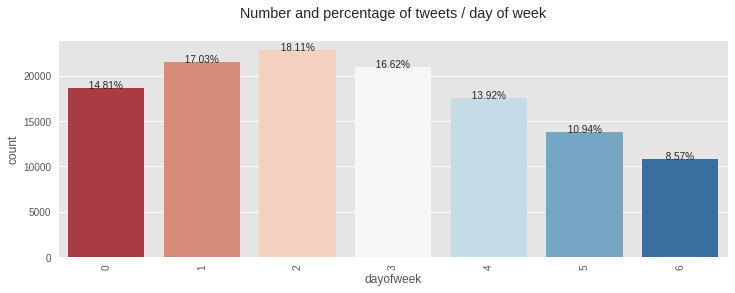

In [32]:
plot_count("dayofweek", "tweets / day of week", tweets_df, size=3, ordered=False)

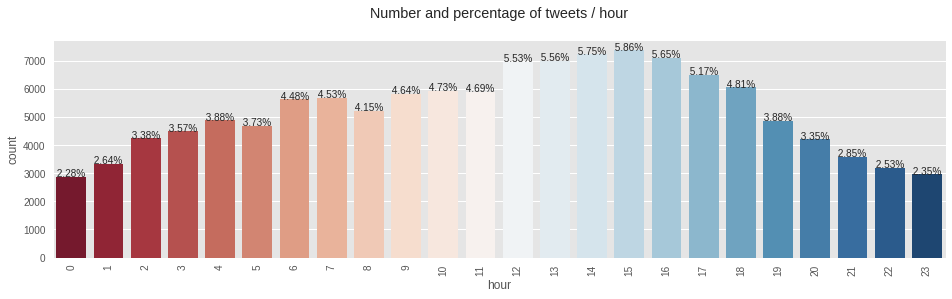

In [33]:
plot_count("hour", "tweets / hour", tweets_df,size=4, ordered=False)

**Pre-processing Of Our Dataset**

In [42]:
'''
The next steps about data cleaning will be:
- Remove URLs from the tweets
- Tokenize text
- Remove emails
- Remove new lines characters
- Remove distracting single quotes
- Remove all punctuation signs
- Lowercase all text
- Detokenize text
- Convert list of texts to Numpy array
'''
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)

    # Remove dpunctuation signs
    data = re.sub("#", " ", data)


        
    return data

In [43]:
temp = []
#Splitting pd.Series to list
data_to_list = tweets_df["text"].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:30])

['Same folks said daikon paste could treat a cytokine storm  PfizerBioNTech ',
 'While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort weve ev… ',
 ' coronavirus  SputnikV  AstraZeneca  PfizerBioNTech  Moderna  Covid_19 Russian vaccine is created to last 2-4 years… ',
 'Facts are immutable, Senator, even when youre not ethically sturdy enough to acknowledge them. (1) You were born i… ',
 'Explain to me again why we need a vaccine  whereareallthesickpeople  PfizerBioNTech… ',
 'Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… ',
 'it is a bit sad to claim the fame for success of  vaccination on patriotic competition between USA, Canada, UK and… ',
 'There have not been many bright days in 2020 but here are some of the best 1.  BidenHarris winning  Election2020… ',
 'Covid vaccine; You getting it?  CovidVaccine  covid19  PfizerBioNTech  Moderna',
 ' CovidVaccine States will start 

In [44]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        

data_words = list(sent_to_words(temp))
print(data_words[:10],'\n')

[['same', 'folks', 'said', 'daikon', 'paste', 'could', 'treat', 'cytokine', 'storm', 'pfizerbiontech'], ['while', 'the', 'world', 'has', 'been', 'on', 'the', 'wrong', 'side', 'of', 'history', 'this', 'year', 'hopefully', 'the', 'biggest', 'vaccination', 'effort', 'weve', 'ev'], ['coronavirus', 'sputnikv', 'astrazeneca', 'pfizerbiontech', 'moderna', 'covid_', 'russian', 'vaccine', 'is', 'created', 'to', 'last', 'years'], ['facts', 'are', 'immutable', 'senator', 'even', 'when', 'youre', 'not', 'ethically', 'sturdy', 'enough', 'to', 'acknowledge', 'them', 'you', 'were', 'born'], ['explain', 'to', 'me', 'again', 'why', 'we', 'need', 'vaccine', 'pfizerbiontech'], ['does', 'anyone', 'have', 'any', 'useful', 'advice', 'guidance', 'for', 'whether', 'the', 'covid', 'vaccine', 'is', 'safe', 'whilst', 'breastfeeding'], ['it', 'is', 'bit', 'sad', 'to', 'claim', 'the', 'fame', 'for', 'success', 'of', 'vaccination', 'on', 'patriotic', 'competition', 'between', 'usa', 'canada', 'uk', 'and'], ['there'

In [45]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['same folks said daikon paste could treat cytokine storm pfizerbiontech', 'while the world has been on the wrong side of history this year hopefully the biggest vaccination effort weve ev', 'coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_ russian vaccine is created to last years', 'facts are immutable senator even when youre not ethically sturdy enough to acknowledge them you were born', 'explain to me again why we need vaccine pfizerbiontech']


In [46]:
data = np.array(data)
#Create a sentiment column
tweets_df["sentiment"] = np.nan

In [47]:
# borrowed from https://www.kaggle.com/pashupatigupta/sentiments-transformer-vader-embedding-bert
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
def find_sentiment(post):
    if sia.polarity_scores(post)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(post)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral" 

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [48]:
tweets_df['sentiment'] = tweets_df['text'].apply(lambda x: find_sentiment(x))
tweets_df.head(25)

id              user_name  ...   date_only sentiment
0   1340539111971516416             Rachel Roh  ...  2020-12-20  Positive
1   1338158543359250433            Albert Fong  ...  2020-12-13  Negative
2   1337858199140118533               eli🇱🇹🇪🇺👌  ...  2020-12-12  Positive
3   1337855739918835717          Charles Adler  ...  2020-12-12   Neutral
4   1337854064604966912   Citizen News Channel  ...  2020-12-12   Neutral
5   1337852648389832708                    Dee  ...  2020-12-12  Positive
6   1337851215875608579      Gunther Fehlinger  ...  2020-12-12  Positive
7   1337850832256176136    Dr.Krutika Kuppalli  ...  2020-12-12  Positive
8   1337850023531347969            Erin Despas  ...  2020-12-12   Neutral
9   1337842295857623042           Ch.Amjad Ali  ...  2020-12-12   Neutral
10  1337841934170255365            Tamer Yazar  ...  2020-12-12   Neutral
11  1337840331522453507                 VoiceM  ...  2020-12-12  Positive
12  1337815730486702087                   WION  ...  2020-12-12  Positive
13  1337809196453081088    Dr.Krutika Kuppalli  ...  2020-12-12  Positive
14  1337807109010780162                  Opoyi  ...  2020-12-12   Neutral
15  1337789467038523394              City A.M.  ...  2020-12-12   Neutral
16  1337789191598575616     STOPCOMMONPASS.ORG  ...  2020-12-12   Neutral
17  1337783770070409218                  ILKHA  ...  2020-12-12   Neutral
18  1337781178665816064  Braderz73🌹#GTTO 🇪🇺 🇬🇧  ...  2020-12-12  Negative
19  1337776763384958976               Alex Vie  ...  2020-12-12  Negative
20  1337774279862185986                   Mani  ...  2020-12-12   Neutral
21  1337774059237629952      Richard Dunne, MD  ...  2020-12-12  Positive
22  1337773965595598848              City A.M.  ...  2020-12-12   Neutral
23  1337773751841144833              BOOM Live  ...  2020-12-12  Negative
24  1337770798770081796        DOCNOS Official  ...  2020-12-12  Positive

[25 rows x 28 columns]

In [49]:
pos = tweets_df['sentiment'].value_counts()
print(pos)

Neutral     61047
Positive    42765
Negative    22094
Name: sentiment, dtype: int64


In [50]:
def plot_sentiment(df, feature, title):
    counts = df[feature].value_counts()
    percent = counts/sum(counts)
    print(percent,"\n")
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    counts.plot(kind='bar', ax=ax1, color='green')
    percent.plot(kind='bar', ax=ax2, color='blue')
    ax1.set_ylabel(f'Counts : {title} sentiments', size=12)
    ax2.set_ylabel(f'Percentage : {title} sentiments', size=12)
    plt.suptitle(f"Sentiment analysis: {title}\n")  
    plt.tight_layout()
    plt.show()

Neutral     0.484862
Positive    0.339658
Negative    0.175480
Name: sentiment, dtype: float64 



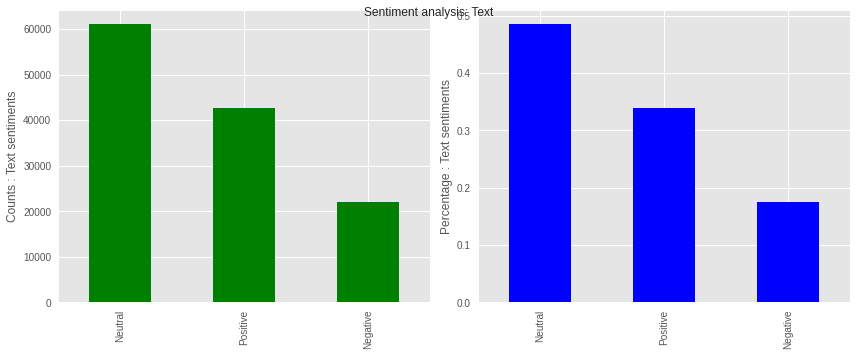

In [51]:
plot_sentiment(tweets_df, 'sentiment', 'Text')

In [52]:
# Label Encoding
labels = np.array(tweets_df["sentiment"])
y = []
for i in range(len(labels)):
    if labels[i] == 'Neutral':
        y.append(0)
    if labels[i] == 'Negative':
        y.append(1)
    if labels[i] == "Positive":
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

**Data sequencing and splitting**

In [53]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint


In [54]:
#Conver the word to vec
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  240 3032   53]
 [   0    0    0 ... 1624 1917 3554]
 [   0    0    0 ...    3  198  312]
 ...
 [   0    0    0 ...   15  632  407]
 [   0    0    0 ...    3   15 4113]
 [   0    0    0 ...  235 1479  657]]


In [55]:
print(labels)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [56]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (f"Our data split form:\n")
print(f"X_train: ",len(X_train))
print(f"X_test: ",len(X_test))
print(f"y_train: ",len(y_train))
print(f"y_test: ", len(y_test))

Our data split form:

X_train:  94429
X_test:  31477
y_train:  94429
y_test:  31477


**Single LSTM**

In [57]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history1 = model1.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/10
2951/2951 [==============================] - 133s 37ms/step - loss: 0.7600 - accuracy: 0.6586 - val_loss: 0.4208 - val_accuracy: 0.8485

Epoch 00001: val_accuracy improved from -inf to 0.84846, saving model to best_model1.hdf5
Epoch 2/10
2951/2951 [==============================] - 109s 37ms/step - loss: 0.4115 - accuracy: 0.8543 - val_loss: 0.3424 - val_accuracy: 0.8896

Epoch 00002: val_accuracy improved from 0.84846 to 0.88960, saving model to best_model1.hdf5
Epoch 3/10
2951/2951 [==============================] - 109s 37ms/step - loss: 0.3398 - accuracy: 0.8905 - val_loss: 0.3233 - val_accuracy: 0.8970

Epoch 00003: val_accuracy improved from 0.88960 to 0.89700, saving model to best_model1.hdf5
Epoch 4/10
2951/2951 [==============================] - 109s 37ms/step - loss: 0.3284 - accuracy: 0.8946 - val_loss: 0.3131 - val_accuracy: 0.9011

Epoch 00004: val_accuracy improved from 0.89700 to 0.90113, saving model to best_model1.hdf5
Epoch 5/10
2951/2951 [=================

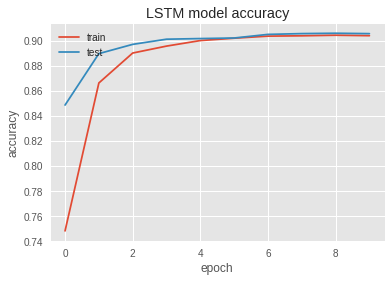

In [58]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

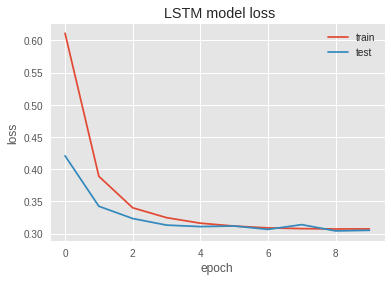

In [59]:
# summarize history for accuracy
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title(' LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [69]:
best_model = keras.models.load_model("./best_model1.hdf5")

In [67]:
lstmpredict = model1.predict(X_test)
print(lstmpredict)

[[0.01434114 0.0143063  0.97135264]
 [0.01071183 0.01048463 0.9788036 ]
 [0.9627123  0.02200794 0.01527974]
 ...
 [0.92407644 0.04718066 0.0287429 ]
 [0.01093294 0.00402883 0.9850382 ]
 [0.01307632 0.9449003  0.04202339]]


In [64]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

984/984 - 12s - loss: 0.3040 - accuracy: 0.9059
Model accuracy:  0.9058995246887207


In [72]:
test_loss, test_acc = best_model.evaluate(lstmpredict, y_test, verbose=2)
print('Model accuracy: ',test_acc)

984/984 - 3s - loss: 1.1352 - accuracy: 0.4811
Model accuracy:  0.4811449646949768


In [73]:
# Plot the classification_report 
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1),np.argmax(lstmpredict, axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     15145
           1       0.85      0.79      0.82      5495
           2       0.88      0.92      0.90     10837

    accuracy                           0.91     31477
   macro avg       0.89      0.88      0.89     31477
weighted avg       0.91      0.91      0.91     31477



**Bidirectional LSTM**

In [75]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))

# Compile the model
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
# Save the Modek
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
# Train the Model
history = model.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/10
2951/2951 [==============================] - 240s 80ms/step - loss: 0.7511 - accuracy: 0.6625 - val_loss: 0.4003 - val_accuracy: 0.8594

Epoch 00001: val_accuracy improved from -inf to 0.85936, saving model to best_model2.hdf5
Epoch 2/10
2951/2951 [==============================] - 233s 79ms/step - loss: 0.3876 - accuracy: 0.8669 - val_loss: 0.3281 - val_accuracy: 0.8956

Epoch 00002: val_accuracy improved from 0.85936 to 0.89557, saving model to best_model2.hdf5
Epoch 3/10
2951/2951 [==============================] - 233s 79ms/step - loss: 0.3280 - accuracy: 0.8939 - val_loss: 0.3271 - val_accuracy: 0.8988

Epoch 00003: val_accuracy improved from 0.89557 to 0.89875, saving model to best_model2.hdf5
Epoch 4/10
2951/2951 [==============================] - 233s 79ms/step - loss: 0.3181 - accuracy: 0.8976 - val_loss: 0.3141 - val_accuracy: 0.9009

Epoch 00004: val_accuracy improved from 0.89875 to 0.90091, saving model to best_model2.hdf5
Epoch 5/10
2951/2951 [=================

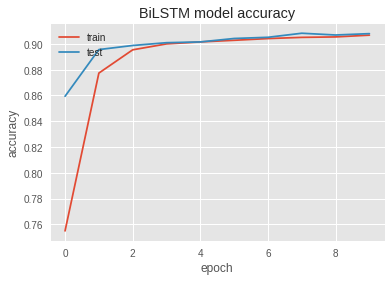

In [76]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BiLSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

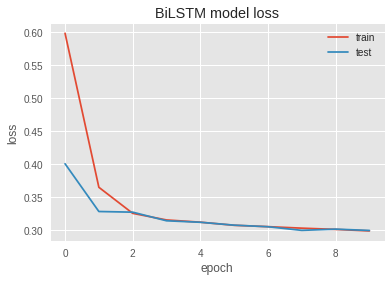

In [77]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BiLSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [79]:
best_model = keras.models.load_model("./best_model2.hdf5")

In [80]:
predictions = best_model.predict(X_test)
print(predictions)

[[0.01829262 0.00797231 0.9737351 ]
 [0.02121087 0.01250506 0.9662841 ]
 [0.95253843 0.02793288 0.01952868]
 ...
 [0.942258   0.03230736 0.02543458]
 [0.02050832 0.00389923 0.97559243]
 [0.01051624 0.9685744  0.02090934]]


In [81]:
test_loss, test_acc = best_model.evaluate(predictions, y_test, verbose=2)
print('Model accuracy: ',test_acc)

984/984 - 4s - loss: 1.0368 - accuracy: 0.4811
Model accuracy:  0.4811449646949768


In [82]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

984/984 - 27s - loss: 0.2996 - accuracy: 0.9083
Model accuracy:  0.9082504510879517


In [83]:
# Plot the classification_report 
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1),np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     15145
           1       0.85      0.79      0.82      5495
           2       0.89      0.91      0.90     10837

    accuracy                           0.91     31477
   macro avg       0.89      0.88      0.89     31477
weighted avg       0.91      0.91      0.91     31477



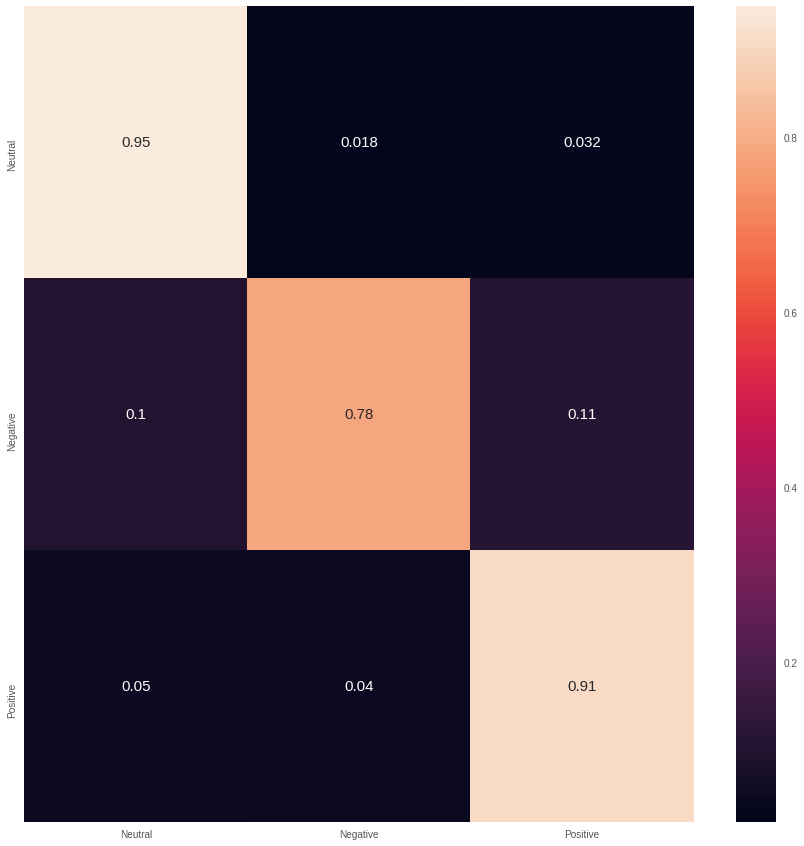

In [84]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])

#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
seaborn.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})


**Let's check if the model can predict** 

In [85]:
sentiment = ['Neutral','Negative','Positive']

In [86]:
sequence = tokenizer.texts_to_sequences(['the trump administration failed to deliver on vaccine promises shocker covidiots coronavirus covidvaccine'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [87]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

In [88]:
sequence = tokenizer.texts_to_sequences(['Facts are immutable Senator even when youre not ethically sturdy enough to acknowledge them.'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Neutral'

**Visualisation About the Vaccine**

In [89]:
# Convert dates
tweets_df['date'] = pd.to_datetime(tweets_df['date'], errors='coerce').dt.date

# Get counts of number of tweets by sentiment for each date
timeline = tweets_df.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

fig = px.line(timeline, x='date', y='tweets', color='sentiment', color_discrete_sequence=["#EF553B", "#636EFA", "#00CC96"], category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

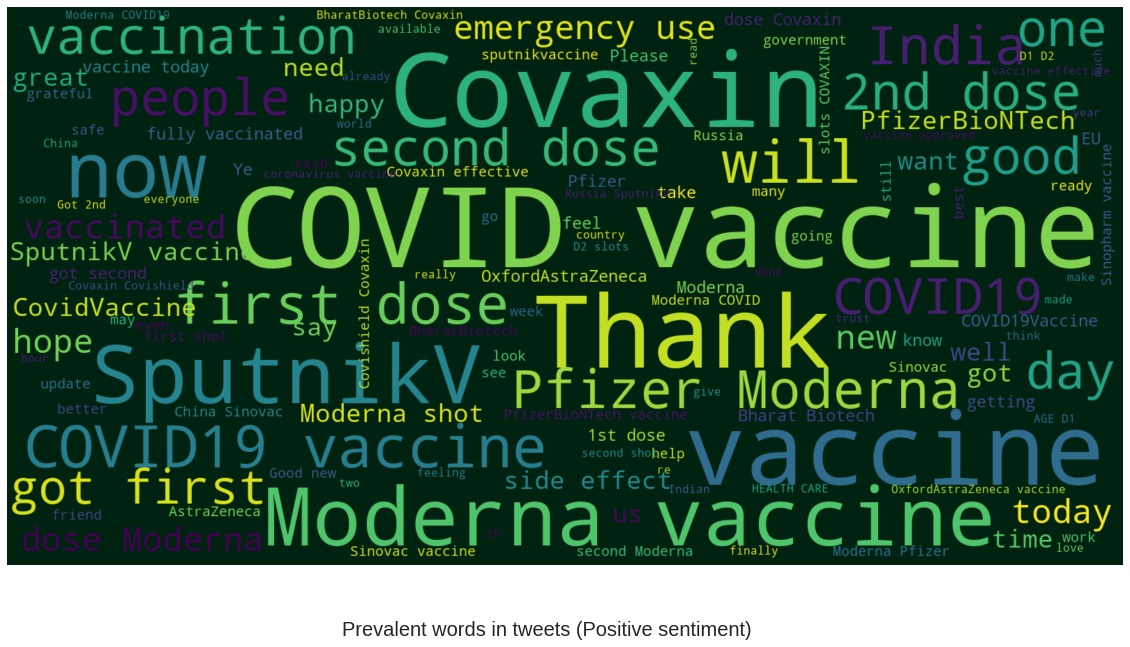

In [90]:
show_wordcloud(tweets_df.loc[tweets_df['sentiment']=='Positive', 'text'], title = 'Prevalent words in tweets (Positive sentiment)')

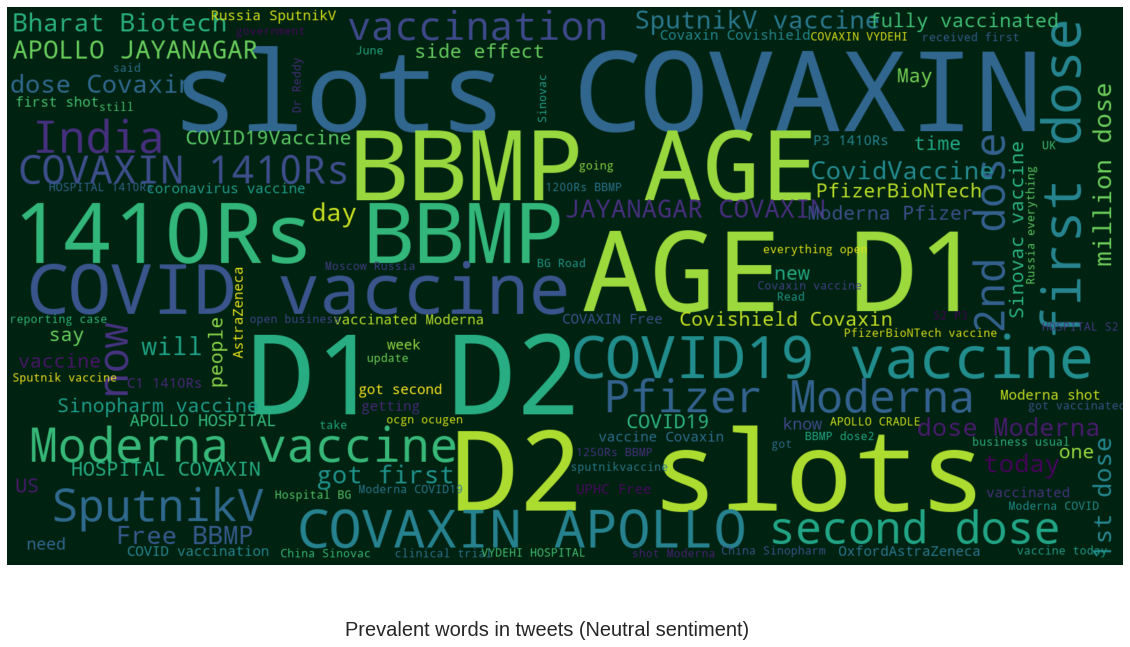

In [91]:
show_wordcloud(tweets_df.loc[tweets_df['sentiment']=='Neutral', 'text'], title = 'Prevalent words in tweets (Neutral sentiment)')

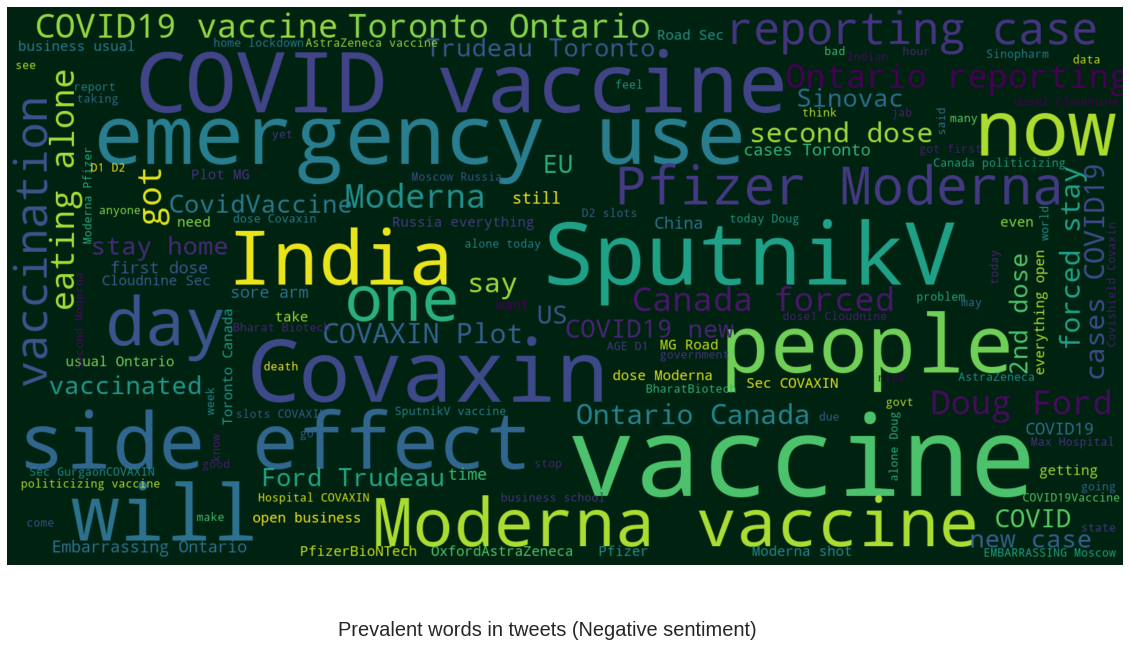

In [92]:
show_wordcloud(tweets_df.loc[tweets_df['sentiment']=='Negative', 'text'], title = 'Prevalent words in tweets (Negative sentiment)')

END